In [1]:
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transforms = v2.Compose([
    v2.ToTensor(),
])

train_complete_set = torchvision.datasets.MNIST('./datasets', train=True, transform=transforms, download=True)
train_set, val_set = random_split(train_complete_set, [0.95, 0.05], torch.Generator().manual_seed(42))

test_set = torchvision.datasets.MNIST('./datasets', train=False, transform=transforms, download=True)

In [4]:
batch_size = 256

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [54]:
class Solver:
    def __init__(self, model, lr=3e-3, reg=0.0, optim=torch.optim.Adam, batch_size=batch_size, criterion=nn.CrossEntropyLoss, print_every=100, anneal=False):
        self.lr = lr
        self.reg = reg
        self.model = model
        self.batch_size = batch_size
        self.optim = optim(model.parameters(), lr=lr, weight_decay=reg)
        self.criterion = criterion()
        self.dataloaders = {}
        self.loss_history = []
        self.print_every = print_every
        self.kl_loss_weight = 0.0001

        self.anneal = anneal
        self.anneal_counter = 0
        self.last_anneal_idx = 0
        self.max_anneal_count = 3

    def set_data_loader(self, loader, split):
        self.dataloaders[split] = loader

    def estimate_loss(self, split):
        dataloader = self.dataloaders[split]

        if dataloader == None:
            return -1.0

        self.model.eval()
        avg_loss = 0.0
        avg_kl_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(dataloader):
                if i % 5000 == 0 and i > 0:
                    break
                images, _ = data
                N = images.shape[0]
                images = images.to(device).reshape(N, -1)

                out, mean, log_var  = self.model(images)
                avg_kl_loss += self.kl_loss_weight * -0.5 * (1 + log_var - mean.square() - log_var.exp()).sum()

                loss = self.criterion(out, images)
                avg_loss += loss.item()

        self.model.train()
        print(f"AVG RECON LOSS: {avg_loss / len(dataloader)} AVG KL LOSS: {avg_kl_loss / len(dataloader)} ")
        return (avg_loss / len(dataloader)) # + (avg_kl_loss / len(dataloader))
    
    def anneal_learning_rate(self):
        num_losses = len(self.loss_history)
        if (self.anneal_counter == self.max_anneal_count
            or num_losses < 3
            or num_losses - self.last_anneal_idx < 3):
            return

        train = [l[0] for l in self.loss_history]
        arr = np.array(train[-3:])
        if arr.std() >= 1e-4:
            return

        self.last_anneal_idx = num_losses
        self.anneal_counter += 1
        print(f"Annealing learning_rate {self.lr} by 10. New learning rate {self.lr / 10}. Anneal count {self.anneal_counter} / {self.max_anneal_count}.")
        self.lr /= 10

    def train(self, loader, epochs=1):
        for e in range(epochs):
            for i, data in enumerate(loader):

                if i % self.print_every == 0 and i > 0:
                    train_loss = self.estimate_loss('train')
                    val_loss = self.estimate_loss('val')
                    
                    print(f"epoch: {e} iter: {i} train_loss: {train_loss} val_loss: {val_loss}")

                    self.loss_history.append((train_loss, val_loss))
                    if self.anneal:
                        self.anneal_learning_rate()

                images, _ = data
                N = images.shape[0]
                images = images.to(device).reshape(N, -1)

                self.optim.zero_grad()

                out, mean, log_var  = self.model(images)
                kl_loss = -0.5 * (1 + log_var - mean.square() - log_var.exp()).mean()
                # print(enc, eps)
                # print(logits, mean, var)
                # break
                # print(out.shape, images.shape, kl_loss.shape)
                loss = self.criterion(out, images)
                
                # if i % 1 == 0:
                #     loss += self.kl_loss_weight * kl_loss

                loss.backward()
                self.optim.step()


In [85]:
class Net(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.leaky_relu = nn.LeakyReLU(0.2)

        self.encoder = nn.Sequential(
            nn.Linear(in_channels, 512, device=device),
            self.leaky_relu,
            nn.Linear(512, 256, device=device),
            self.leaky_relu,
            nn.Linear(256, out_channels, device=device),
            self.leaky_relu,
        )

        self.decoder = nn.Sequential(
            nn.Linear(out_channels, 256, device=device),
            self.leaky_relu,
            nn.Linear(256, 512, device=device),
            self.leaky_relu,
            nn.Linear(512, in_channels, device=device),
            nn.Sigmoid(),
        )
        self.ln_mean = nn.Linear(out_channels, out_channels, device=device)
        self.ln_var  = nn.Linear(out_channels, out_channels, device=device)

    def forward(self, input):
        mean, log_var = self.encode(input)
        q = self.reparameterize(mean, log_var)
        x = self.decode(q)
        return [x, mean, log_var]
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps  = torch.randn_like(std, requires_grad=False)

        return mean + (std * eps)

    def encode(self, x):
        encoded = self.encoder(x)
        mean = self.ln_mean(encoded)
        log_var  = self.ln_var(encoded)
        
        return [mean, log_var]

    def decode(self, embd):
        return self.decoder(embd)

In [86]:
model = Net(784, 100)
solver = Solver(model, lr=0.001, batch_size=batch_size, criterion=nn.BCELoss)
solver.set_data_loader(train_loader, 'train')
solver.set_data_loader(val_loader, 'val')

In [87]:
solver.train(train_loader, 5)

AVG RECON LOSS: 0.23504105531046743 AVG KL LOSS: 2.0220999717712402 
AVG RECON LOSS: 0.23362804080049196 AVG KL LOSS: 2.0210063457489014 
epoch: 0 iter: 100 train_loss: 0.23504105531046743 val_loss: 0.23362804080049196
AVG RECON LOSS: 0.17753976924269724 AVG KL LOSS: 7.6715168952941895 
AVG RECON LOSS: 0.17659000679850578 AVG KL LOSS: 7.587379455566406 
epoch: 0 iter: 200 train_loss: 0.17753976924269724 val_loss: 0.17659000679850578
AVG RECON LOSS: 0.14627189479868508 AVG KL LOSS: 13.617664337158203 
AVG RECON LOSS: 0.14571518450975418 AVG KL LOSS: 13.396876335144043 
epoch: 1 iter: 100 train_loss: 0.14627189479868508 val_loss: 0.14571518450975418
AVG RECON LOSS: 0.13832989695895412 AVG KL LOSS: 19.252424240112305 
AVG RECON LOSS: 0.13786005352934202 AVG KL LOSS: 18.96515655517578 
epoch: 1 iter: 200 train_loss: 0.13832989695895412 val_loss: 0.13786005352934202
AVG RECON LOSS: 0.12236480428231672 AVG KL LOSS: 22.50490951538086 
AVG RECON LOSS: 0.12257658193508784 AVG KL LOSS: 22.164916

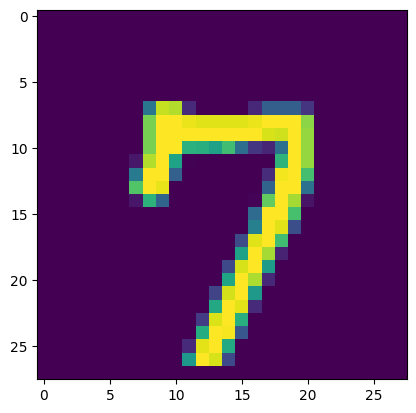

In [111]:
img = train_set[83][0]
plt.imshow(img.reshape(28, 28))

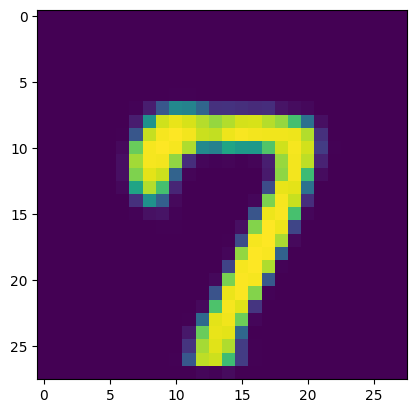

In [110]:
img = img.to(device).reshape(1, 784)
x, mean, log_var = model(img)
plt.imshow(x.reshape(28, 28).cpu().detach().numpy())

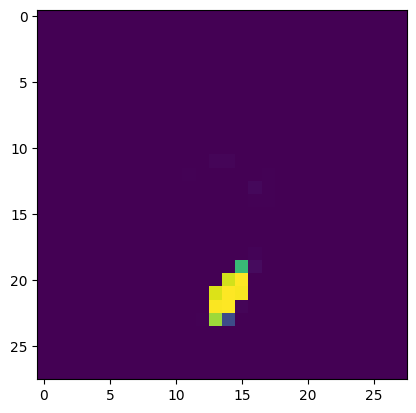

In [109]:
rand_img = torch.randn_like(img).to(device).reshape(1, 784)
x, mean, log_var = model(rand_img)
plt.imshow(x.reshape(28, 28).cpu().detach().numpy())